In [20]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import yfinance as yf
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM,  Dropout,  Dense, Bidirectional
import matplotlib.pyplot as plt
plt.style.use("bmh")

In [21]:

# Step 1: Data cleaning
data = yf.download(tickers='BTC-usd', period='max', interval='1d')
data.dropna(inplace=True)
data


[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100
...,...,...,...,...,...,...
2023-01-31,22840.796875,23225.021484,22765.568359,23139.283203,23139.283203,22837828665
2023-02-01,23137.835938,23764.539062,22877.750000,23723.769531,23723.769531,26683255504
2023-02-02,23720.824219,24167.210938,23468.595703,23471.871094,23471.871094,32066936882


In [22]:

data.drop([ 'Close'], axis=1, inplace=True)
# Datetime conversion
data['Date'] = pd.to_datetime(data.index)

# Setting the index
data.set_index('Date', inplace=True)

# Dropping any NaNs
data.dropna(inplace=True)

data.info()
data.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3063 entries, 2014-09-17 to 2023-02-04
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3063 non-null   float64
 1   High       3063 non-null   float64
 2   Low        3063 non-null   float64
 3   Adj Close  3063 non-null   float64
 4   Volume     3063 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 143.6 KB


,Open,High,Low,Adj Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [23]:
# Keep track of original date values

# Scale the data between 0 and 1
scaler = MinMaxScaler()
data = scaler.fit_transform(data)
print(data.shape)

(3063, 5)


In [24]:
# Step 6: Building the Bidirectional LSTM model (cont.)
model = Sequential()
model.add(LSTM(100, input_shape=( 1,  data.shape[1]), return_sequences=True , activation= 'tanh'))
model.add(Dropout(0.2))
model.add(LSTM(100, activation= 'tanh'))
model.add(Dropout(0.2))
model.add(Dense(5))
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 1, 100)            42400     
                                                                 
 dropout_2 (Dropout)         (None, 1, 100)            0         
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 505       
                                                                 
Total params: 123,305
Trainable params: 123,305
Non-trainable params: 0
_________________________________________________________________


In [25]:
from sklearn.model_selection import TimeSeriesSplit

# Define the cross-validator
tscv = TimeSeriesSplit(n_splits=5)

# Loop through each fold and fit/evaluate the model
for train_index, test_index in tscv.split(data):
    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = data[train_index], data[test_index]

print('x_test',X_test.shape)
print('y_test',y_test.shape)
print("X_train",X_train.shape)
print('y_train',y_train.shape)





x_test (510, 5)
y_test (510, 5)
X_train (2553, 5)
y_train (2553, 5)


In [7]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(16,5))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(16,5))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()

In [8]:
# Reshape the data to a 3D array for use in the LSTM model
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [9]:
# Step 7: Training and evaluating the model
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/500
80/80 [==============================] - 13s 42ms/step - loss: 0.0165 - accuracy: 0.2342 - val_loss: 0.0034 - val_accuracy: 0.1000
Epoch 2/500
80/80 [==============================] - 1s 11ms/step - loss: 9.5742e-04 - accuracy: 0.2675 - val_loss: 8.3922e-04 - val_accuracy: 0.1000
Epoch 3/500
80/80 [==============================] - 1s 12ms/step - loss: 7.3103e-04 - accuracy: 0.2005 - val_loss: 9.7399e-04 - val_accuracy: 0.3216
Epoch 4/500
80/80 [==============================] - 1s 13ms/step - loss: 6.8357e-04 - accuracy: 0.2421 - val_loss: 8.3893e-04 - val_accuracy: 0.3059
Epoch 5/500
80/80 [==============================] - 1s 14ms/step - loss: 6.2626e-04 - accuracy: 0.2350 - val_loss: 6.7583e-04 - val_accuracy: 0.1000
Epoch 6/500
80/80 [==============================] - 1s 12ms/step - loss: 6.2067e-04 - accuracy: 0.2103 - val_loss: 0.0015 - val_accuracy: 0.3216
Epoch 7/500
80/80 [==============================] - 1s 14ms/step - loss: 5.8752e-04 - accuracy: 0.2362 - val_l

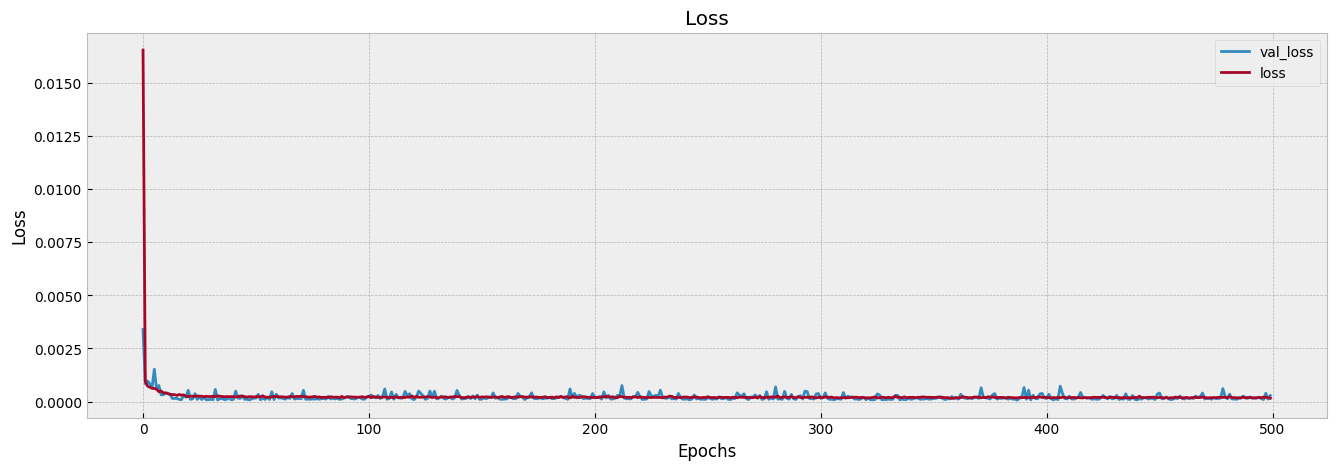

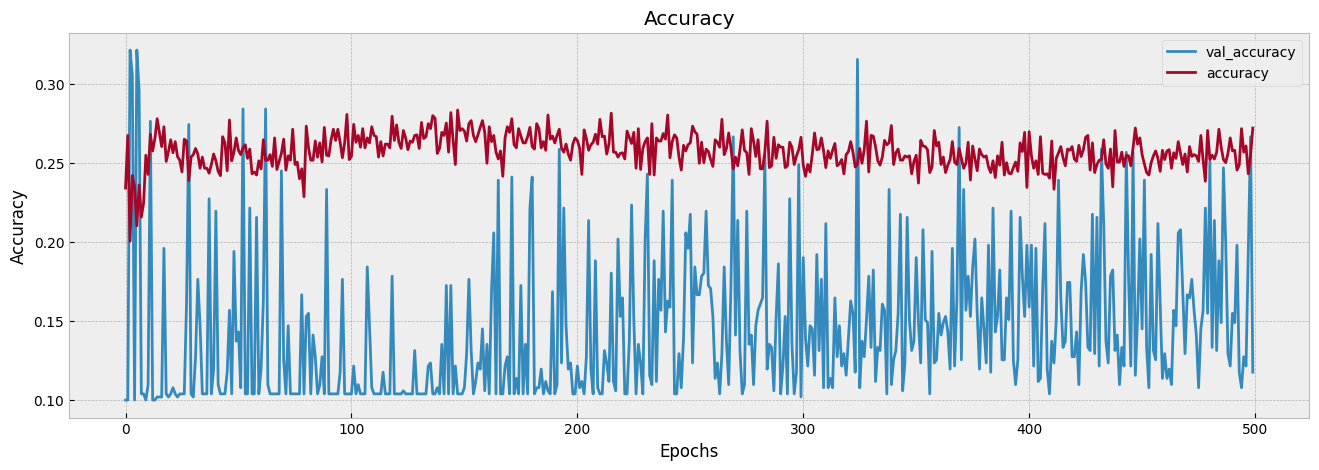

In [10]:
visualize_training_results(history)

In [11]:
# Evaluate the model on the test set
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score)


Test loss: [0.0002860293607227504, 0.11764705926179886]


In [12]:

# Step 8: Tuning the Hyperparameters
# You can use techniques such as grid search or random search to find the best values for the model's hyperparameters

# Step 9: Testing the model
y_pred = model.predict(X_test)
print('y_pred',y_pred.shape)
print('y_test',y_test.shape)


y_pred = scaler.inverse_transform(y_pred)

y_test = scaler.inverse_transform(y_test)
y_pred_df = pd.DataFrame(y_pred, columns=["Open", "High", "Low", "Adj Close", "Volume"])
y_test_df = pd.DataFrame(y_test, columns=["Open", "High", "Low", "Adj Close", "Volume"])

# Get the length of y_pred
y_pred_length = y_pred.shape[0]
y_test_length = y_test.shape[0]

# Generate dates for the next y_pred_length days
today = pd.Timestamp.now().date()
prediction_dates = today - timedelta(days=y_pred_length-1)
test = today - timedelta(days=y_test_length-1)
prediction = pd.date_range(start=prediction_dates, end=today, freq='D')
test_dates = pd.date_range(start=test,end=today, freq='D')

# Use the generated dates as the index of the DataFrame
y_pred_df['Date'] = prediction

y_test_df['Date'] = test_dates

# Set the index of the dataframes to be the 'Date' column
y_pred_df.set_index('Date', inplace=True)
y_test_df.set_index('Date', inplace=True)




16/16 [==============================] - 2s 5ms/step
y_pred (510, 5)
y_test (510, 5)


In [13]:
#evaluat
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mape = 100 * np.mean(np.abs((y_test - y_pred) / y_test))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAPE: {:.4f}%".format(mape))
print("RMSE: {:.4f}".format(rmse))
print("MSE: {:.4f}".format(mse))
print("MAE:{:.4f}".format(mae))

MAPE: 2.7674%
RMSE: 600238768.2938
MSE: 360286578962807936.0000
MAE:205865369.6921


In [14]:
y_pred_df

,Open,High,Low,Adj Close,Volume
Date,,,,,
2021-09-13,44498.316406,45847.625000,43349.285156,44653.945312,3.997448e+10
2021-09-14,45138.738281,46460.285156,44110.183594,45337.507812,3.756742e+10
2021-09-15,46530.421875,47764.109375,45803.957031,46820.144531,3.104489e+10
2021-09-16,46819.230469,48070.261719,46049.414062,47095.070312,3.225905e+10
2021-09-17,46405.886719,47619.019531,45726.570312,46706.312500,2.974416e+10
...,...,...,...,...,...
2023-01-31,22318.117188,23043.447266,21728.218750,22444.345703,2.224591e+10
2023-02-01,22701.527344,23461.783203,22042.478516,22814.542969,2.579398e+10
2023-02-02,23102.630859,23905.751953,22350.314453,23194.457031,3.087416e+10


In [15]:
y_test_df

,Open,High,Low,Adj Close,Volume
Date,,,,,
2021-09-13,46057.214844,46598.679688,43591.320312,44963.074219,4.096994e+10
2021-09-14,44960.050781,47218.125000,44752.332031,47092.492188,3.865215e+10
2021-09-15,47098.000000,48450.468750,46773.328125,48176.347656,3.048450e+10
2021-09-16,48158.906250,48486.828125,47079.558594,47783.359375,3.176429e+10
2021-09-17,47771.003906,48160.921875,46832.523438,47267.519531,2.872771e+10
...,...,...,...,...,...
2023-01-31,22840.796875,23225.021484,22765.568359,23139.283203,2.283783e+10
2023-02-01,23137.835938,23764.539062,22877.750000,23723.769531,2.668326e+10
2023-02-02,23720.824219,24167.210937,23468.595703,23471.871094,3.206694e+10


In [16]:
def smape(y_true, y_pred):
    return 200 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

SMAPE1 = smape(y_test, y_pred)
print("smape: {:.4f}%".format(SMAPE1))

smape: 2.7885%


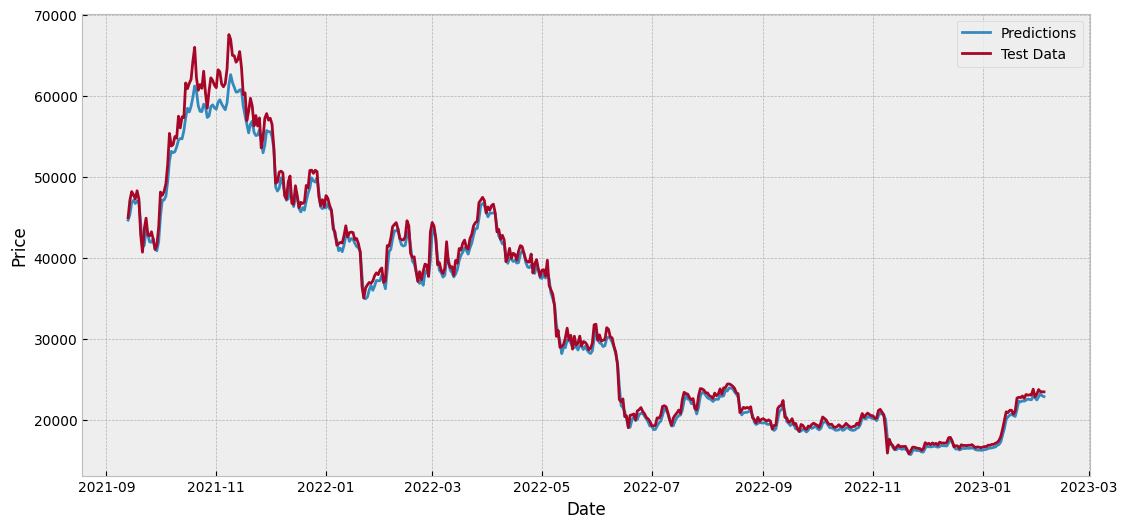

In [17]:
import matplotlib.pyplot as plt

# Assume that you have stored the date information in a variable called 'date'
# Assume that you have stored the predictions in a variable called 'y_pred'
# Assume that you have stored the test data in a variable called 'y_test'

# Plot the test data and predictions on a line chart
plt.figure(figsize=(13,6))
plt.plot(y_pred_df['Adj Close'], label='Predictions')
plt.plot(y_test_df['Adj Close'], label='Test Data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [18]:
# Use the trained model to make predictions
future_predictions = model.predict(X_test[-10:, :].reshape(10, 1, X_test.shape[2]))


# Inverse transform the predictions back to the original scale
future_predictions = scaler.inverse_transform(future_predictions)
# Creating a DF of the predicted prices

future_predictions = pd.DataFrame(future_predictions, columns=["Open", "High", "Low", "Adj Close", "Volume"])

# Generate dates for the next 10 days
today = pd.Timestamp.now().date()
prediction_dates = pd.date_range(today, periods=10, freq='D')

# Add back the date values to the DataFrame
future_predictions['Date'] = prediction_dates
future_predictions.set_index('Date', inplace=True)

# Print the predictions
print(future_predictions)



1/1 [==============================] - 0s 72ms/step
                    Open          High           Low     Adj Close  \
Date                                                                 
2023-02-04  22440.972656  23189.640625  21794.865234  22553.218750   
2023-02-05  22382.621094  23125.996094  21746.601562  22496.763672   
2023-02-06  22307.570312  22985.958984  21842.378906  22466.751953   
2023-02-07  22756.611328  23522.437500  22086.556641  22867.568359   
2023-02-08  22608.398438  23372.660156  21926.169922  22711.527344   
2023-02-09  22318.117188  23043.447266  21728.218750  22444.345703   
2023-02-10  22701.527344  23461.783203  22042.478516  22814.542969   
2023-02-11  23102.630859  23905.751953  22350.314453  23194.457031   
2023-02-12  22828.302734  23593.400391  22163.132812  22940.726562   
2023-02-13  22698.527344  23400.513672  22195.798828  22853.148438   

                  Volume  
Date                      
2023-02-04  2.549424e+10  
2023-02-05  2.462561e+10  

Original values for the next 10 days:
Date
2023-02-04    22553.218750
2023-02-05    22496.763672
2023-02-06    22466.751953
2023-02-07    22867.568359
2023-02-08    22711.527344
2023-02-09    22444.345703
2023-02-10    22814.542969
2023-02-11    23194.457031
2023-02-12    22940.726562
2023-02-13    22853.148438
Name: Adj Close, dtype: float32


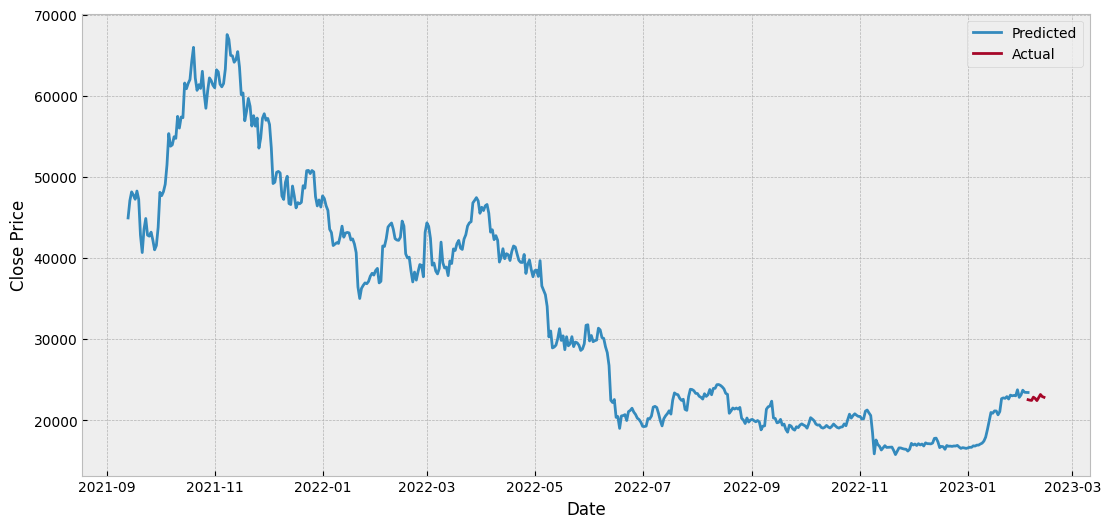

In [19]:
import matplotlib.pyplot as plt



print("Original values for the next 10 days:")
print(future_predictions['Adj Close'])

# Plot the predictions and the true values
plt.figure(figsize=(13,6))
plt.plot(y_test_df['Adj Close'], label='Actual')
plt.plot(future_predictions['Adj Close'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend(["Predicted", "Actual"])
plt.show()
